# Problem 2 - Precision, Recall, ROC

## 2.1

**Answer:**
The ROC (Receiver Operating Characteristic) curve plots True Positive Rate (TPR) against False Positive Rate (FPR), where:
- $TPR = TP / (TP + FN)$
- $FPR = FP / (FP + TN)$

From the above formulas, it's evident that the ROC curve takes into account True Negatives ($TN$). Specifically, the $FPR$ is dependent on the number of True Negatives.

The Precision-Recall ($PR$) curve, on the other hand, plots Precision against Recall, where:
- $Precision = TP / (TP + FP)$
- $Recall = TP / (TP + FN)$ (which is the same as TPR)

From these formulas, it is evident that the PR curve does not take into account True Negatives. Precision and Recall are only concerned with the correct prediction of the positive class (True Positives) and the misclassification of the positive class (False Negatives and False Positives).

While each point on the ROC curve corresponds to a unique point on the PR curve, they are also different in some ways:

- The ROC curve evaluates the ability of a binary classifier to distinguish between the positive and negative classes across different thresholds, taking into account both True Positives and True Negatives.

- The PR curve focuses solely on the performance of the classifier with respect to the positive class. Each point on the ROC curve, which represents a specific threshold, corresponds to a unique point on the PR curve because changing the threshold will affect both TPR (or Recall) and Precision.

## 2.2

**Link to dataset:**
https://www.openml.org/search?type=data&status=active&id=1464

In [29]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
# Fetch the data
data = fetch_openml(data_id=1464, return_X_y=False, as_frame=True)
data = data["frame"]
X = data.drop(columns = ['Class'])
y = data['Class']
# Handling missing values
X.fillna(X.mean(), inplace=True)  # Fill NaN with the mean value of each column
y.dropna(inplace=True)  # Drop any NaN values in the target column
print(data)

       V1    V2       V3    V4 Class
0     2.0  50.0  12500.0  98.0     2
1     0.0  13.0   3250.0  28.0     2
2     1.0  16.0   4000.0  35.0     2
3     2.0  20.0   5000.0  45.0     2
4     1.0  24.0   6000.0  77.0     1
..    ...   ...      ...   ...   ...
743  23.0   2.0    500.0  38.0     1
744  21.0   2.0    500.0  52.0     1
745  23.0   3.0    750.0  62.0     1
746  39.0   1.0    250.0  39.0     1
747  72.0   1.0    250.0  72.0     1

[748 rows x 5 columns]


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [30]:
# Map '1' to 0 and '2' to 1
y = y.map({'1': 0, '2': 1})
# Splitting the data (assuming X and y are your features and labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Data Oversampling using SMOTE:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Train the classifiers on the oversampled data
ada = AdaBoostClassifier().fit(X_train_smote, y_train_smote)
logreg = LogisticRegression().fit(X_train_smote, y_train_smote)

# Getting the probabilities
ada_probs = ada.predict_proba(X_test_scaled)[:, 1]
logreg_probs = logreg.predict_proba(X_test_scaled)[:, 1]

# ROC curves
fpr_ada, tpr_ada, _ = roc_curve(y_test, ada_probs)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)

# Precision-Recall curves
precision_ada, recall_ada, _ = precision_recall_curve(y_test, ada_probs)
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, logreg_probs)

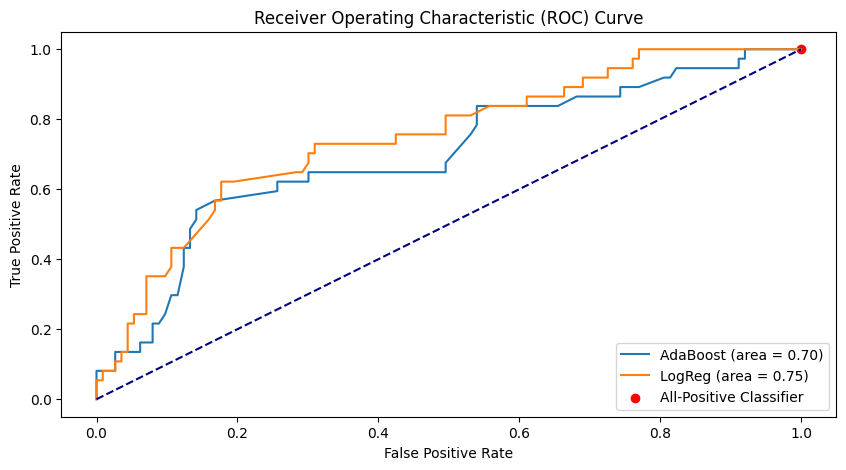

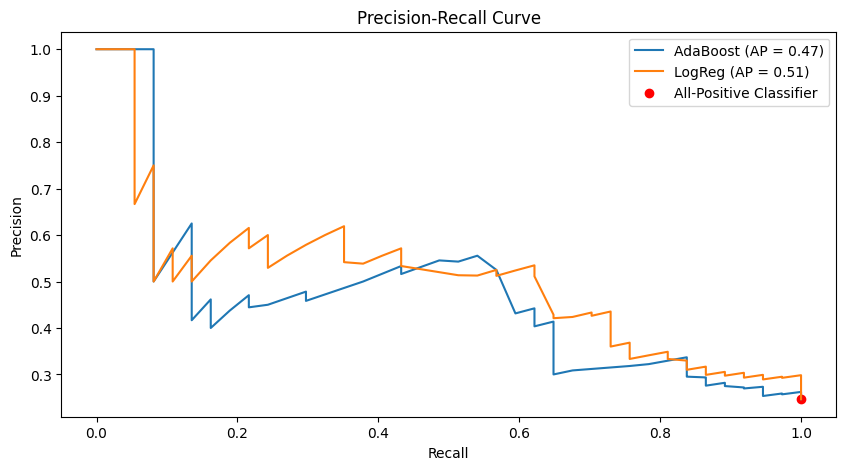

In [31]:
# ROC Plot
plt.figure(figsize=(10, 5))
plt.plot(fpr_ada, tpr_ada, label='AdaBoost (area = %0.2f)' % auc(fpr_ada, tpr_ada))
plt.plot(fpr_logreg, tpr_logreg, label='LogReg (area = %0.2f)' % auc(fpr_logreg, tpr_logreg))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.scatter(1, 1, color='red', label='All-Positive Classifier')  # Point for all-positive classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Plot
all_positive_precision = y_test.astype(int).mean()  # Proportion of actual positives
plt.figure(figsize=(10, 5))
plt.plot(recall_ada, precision_ada, label='AdaBoost (AP = %0.2f)' % average_precision_score(y_test, ada_probs))
plt.plot(recall_logreg, precision_logreg, label='LogReg (AP = %0.2f)' % average_precision_score(y_test, logreg_probs))
plt.scatter(1, all_positive_precision, color='red', label='All-Positive Classifier')  # Point for all-positive classifier
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()